In [16]:
import sys

sys.path.append("..")

['/home/bnicol/Documents/ENSC/3A-AI/IngeLogIA/IngeLogIAIdiwii/notebooks', '/home/bnicol/miniconda3/envs/coursIA/lib/python38.zip', '/home/bnicol/miniconda3/envs/coursIA/lib/python3.8', '/home/bnicol/miniconda3/envs/coursIA/lib/python3.8/lib-dynload', '', '/home/bnicol/miniconda3/envs/coursIA/lib/python3.8/site-packages', '/home/bnicol/miniconda3/envs/coursIA/lib/python3.8/site-packages/IPython/extensions', '/home/bnicol/.ipython', '..', '..']


In [ ]:
import json

In [3]:
from source.Prediction import makePrediction, makeAllPredictions, maxPredictions
from source.Visualisation import totalNumberOfItems, itemsInClasses, classesDistribution, getSentence, getIntent, computeMetrics, plotGlobalConfusionMatrix, plotROC, threshold

# Exemple avec une phrase

In [4]:
# Test using sample sentence
sentence = "Je voudrais manger au restaurant ce soir"
  
# Making request
data = makePrediction(sentence)

# Printing the output 
print("Results :\n", data) 

Results :
 {'find-train': 0.003149856347590685, 'irrelevant': 0.16539081931114197, 'find-flight': 0.0028878021985292435, 'find-restaurant': 0.7818630337715149, 'purchase': 0.010286014527082443, 'find-around-me': 0.003812880488112569, 'provide-showtimes': 0.02780276909470558, 'find-hotel': 0.004806765355169773}


# Format de réponse

Il existe 8 catégories différentes pour la classifications des intentions dans le modèle proposé :
- find-train : Trouver un train
- irrelevant : Non pertinent
- find-flight : Trouver un vol
- find-restaurant : Trouver un restaurant
- purchase : Trouver des renseignements concernant un achat (prix, disponibilité, etc...) ou Trouver un article 
- find-around-me : Trouver un lieu faisant une activité autour de soi (ou d'une zone donnée dans la requête)
- provide-showtimes : Trouver des informations pour un film
- find-hotel : Trouver un hotel

# Lecture des données

In [5]:
# Reading training data
with open('../data/processed/training_set.json') as f:
  trainingData = json.load(f)

with open('../data/processed/testing_set.json') as f:
  testingData = json.load(f)

# Sentence example
print(trainingData[0])

{'intent': 'irrelevant', 'sentence': '850€ maximum pour le loyer, à partir de janvier si possible'}


# Visualisation des données d'entraînement

Total number of items :  6035
Item for each intent :
 {'find-train': 143, 'find-flight': 142, 'find-restaurant': 469, 'purchase': 613, 'find-around-me': 383, 'provide-showtimes': 117, 'find-hotel': 316, 'irrelevant': 3852}


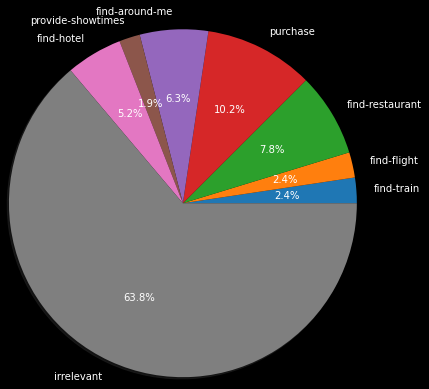

In [6]:
print("Total number of items : ", totalNumberOfItems(trainingData))

classes = itemsInClasses(trainingData)
print("Item for each intent :\n", classes)

#Distribution plot
classesDistribution(trainingData, classes)

On peut voir sur le graphique ci-dessus que les intentions ne sont pas du tout correctement distribués dans le training data. Par conséquent le modèle entraîné va être biaisé et ne fonctionnera pas optimalement si cette distribution ne correspond pas à celle qui a lieu en production

# Visualisation des données de test

Total number of items :  1065
Item for each intent :
 {'find-train': 21, 'find-flight': 24, 'find-restaurant': 93, 'purchase': 114, 'find-around-me': 67, 'provide-showtimes': 14, 'find-hotel': 55, 'irrelevant': 677}


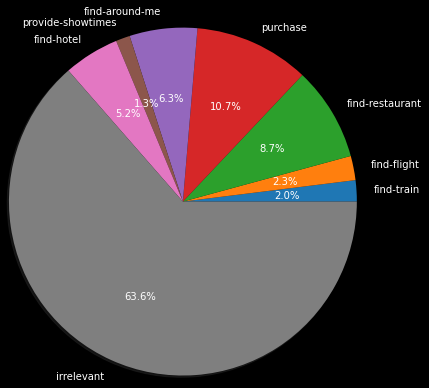

In [7]:
print("Total number of items : ", totalNumberOfItems(testingData))

classes = itemsInClasses(testingData)
print("Item for each intent :\n", classes)

#Distribution plot
classesDistribution(testingData, classes)

On peut voir ci-dessus que les données de test sont aussi mal distribuées que les données d'entraînement

# Métrique du modèle

Nous allons ici calculer la précision, le rappel et le score f1 à l'aide des données de test

In [8]:
# Getting sentences and intents
testSentence = getSentence(testingData)
testIntent = getIntent(testingData)

In [9]:
# Making predictions
results = makeAllPredictions(testSentence)
resultsMax = maxPredictions(results)

### Calcul de la précision, du rappel et du score f1

In [10]:
# Computing precision, recall and f1
precision, recall, f1 = computeMetrics(testIntent, resultsMax)

print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1)

Precision: 0.816473
Recall: 0.804695
F1 score: 0.783963


Les scores sont correctes, autour de 80 %, sans être excellents. Le F1 score, une représentation qui veut généraliser les deux précédentes, est plus faible.

### Matrices de confusion

In [ ]:
# Confusion matrix without irrelevant
plotGlobalConfusionMatrix(testIntent, resultsMax, irrelevant=False)

La lecture des résultats est noyé par la classe "irrelevant", beaucoup plus nombreuse. Nous analysons donc les résultats en ignorant cette classe.

In [ ]:
# Confusion matrix without irrelevant
plotGlobalConfusionMatrix(testIntent, resultsMax, irrelevant=False)

Bien qu'une majorité de résultats soient bien classifiés, on observe une série d'erreurs, notamment entre purchase (dont l'échantillon de test est faible) et "find around me", ce qui pourrait être indicateur d'un problème de performance.

### Courbe ROC

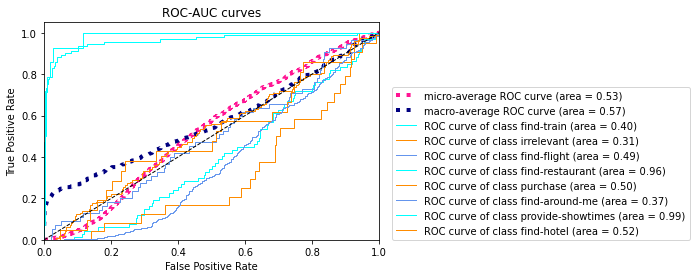

In [13]:
plotROC(results, testIntent, resultsMax)

Les classes "find-restaurant" et "provide-showtime" sont les seules à donner des scores ROC correctes, les autres avoisinent les 50%, ce qui dénote une incapacité à différentier les classes. "Provide showtime" est une classe très peu présent dans les data-sets, et son bon score ici ne sera pas nécessairement représentatif des résultats en production

# Threshold

In [15]:
threshold(results, testIntent):

{'find-train': 0.019063251093029976, 'irrelevant': 0.38808488845825195, 'find-flight': 0.02717919461429119, 'find-restaurant': 0.053374409675598145, 'purchase': 0.39877641201019287, 'find-around-me': 0.0745929405093193, 'provide-showtimes': 0.010972157120704651, 'find-hotel': 0.02795671485364437}
irrelevant
Tu sais où je peux acheter un bazooka ?
